# Simulation

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import scvi

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import scp.simulations as sm
import scp.plots as pl
from scp.models import PROTVI

scvi.settings.seed = 0
sm.fix_seed(0)

## Generation

In [4]:
n_datasets = 10

datasets = []
for i in range(n_datasets):
    #adata = sm.simulate_two_groups(log2_fold_change=0)
    adata = sm.simulate_group()
    datasets.append(adata)

## Inspection

Let's look at one of the simulated datasets.

In [5]:
adata = datasets[0]

print(f"Number of cells: {adata.n_obs}")
print(f"Number of proteins: {adata.n_vars}")

mask = adata.layers["detected"]
n_obs = np.mean(mask)

print(f"Observed intensities: {n_obs*100:.2f}%")

Number of cells: 1000
Number of proteins: 900
Observed intensities: 62.12%


Let's look at the expression matrix.

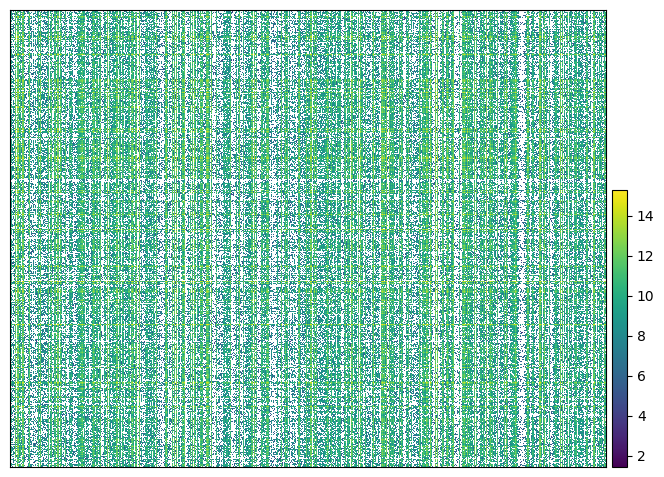

In [6]:
adata.X = adata.layers["intensity"].copy()
adata.X[adata.layers["detected"] == 0] = np.nan

sc.pl.heatmap(adata, var_names=adata.var_names, groupby="group", show_gene_labels=False)

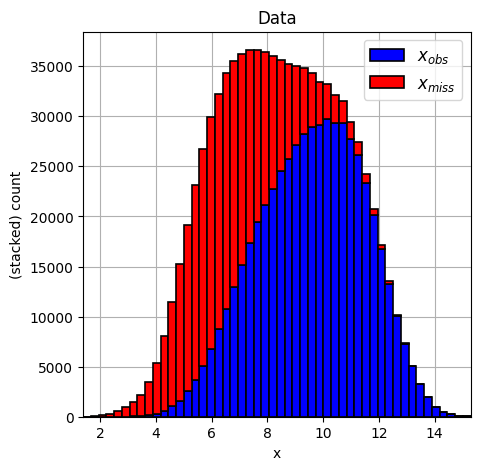

In [7]:
mask = adata.layers["detected"]
x = adata.layers["intensity"].copy()

x_obs = x[mask]
x_miss = x[~mask]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.hist([x_obs, x_miss], color=["blue", "red"], bins=50, edgecolor="black", linewidth=1.2, stacked=True)
ax.set_title("Data")
ax.set_xlabel("x")
ax.set_ylabel("(stacked) count")
ax.set_xlim(np.min(x), np.max(x))
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(labels=["$x_{obs}$", "$x_{miss}$"], fontsize=12)

Let's look at the protein detection proportion and intensity.

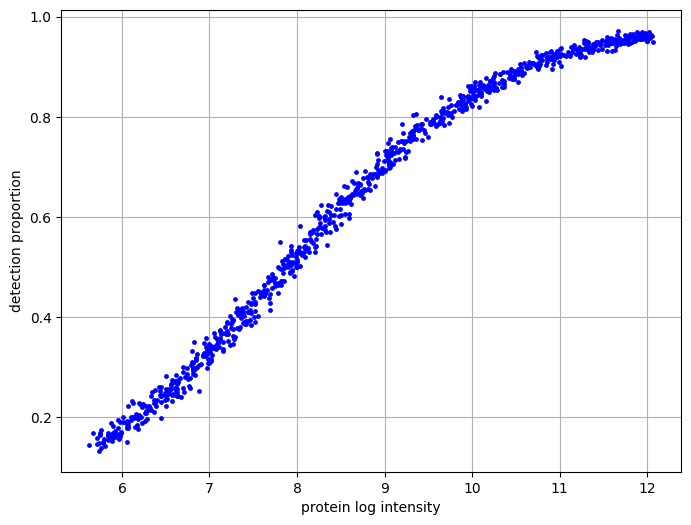

In [8]:
pl.scatter_protein_detection_proportion_and_intensity(adata.X)

## Modelling

Let's fit a few models to the data.

### PROTVI

In [9]:
adata = datasets[0]

In [10]:
adata.X = adata.layers["intensity"] * adata.layers["detected"]

In [11]:
PROTVI.setup_anndata(adata)

model = PROTVI(adata, log_variational=False)
#model.view_anndata_setup()

In [12]:
model.train(max_epochs=800, plan_kwargs={"lr": 3e-3, "mechanism_weight": 1})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 800/800: 100%|██████████| 800/800 [03:18<00:00,  2.02it/s, v_num=1, train_loss_step=588, train_loss_epoch=377]        

`Trainer.fit` stopped: `max_epochs=800` reached.


Epoch 800/800: 100%|██████████| 800/800 [03:18<00:00,  4.02it/s, v_num=1, train_loss_step=588, train_loss_epoch=377]


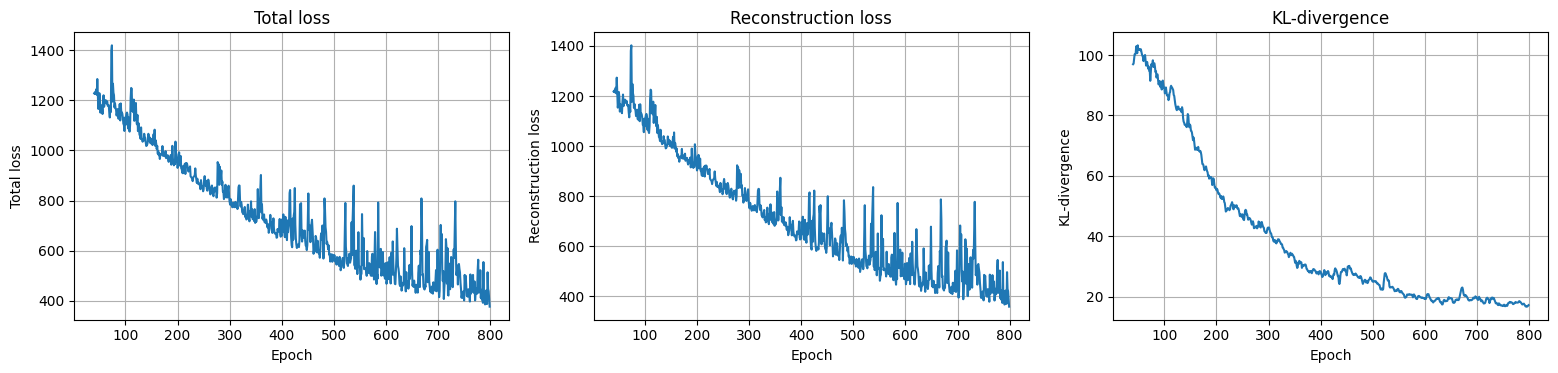

In [13]:
pl.plot_loss(model.history, n_skip=40)

In [14]:
x_est, p_est = model.impute(adata)

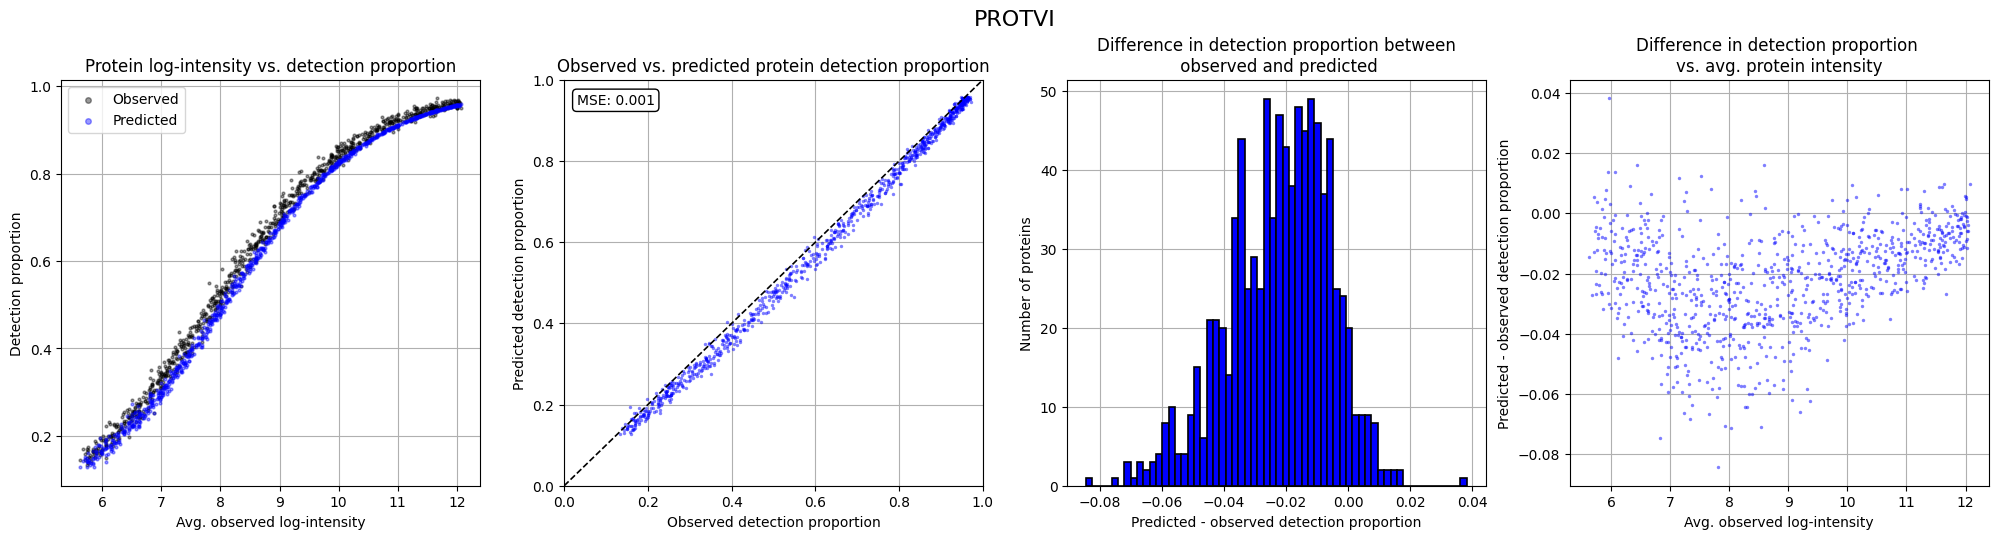

In [15]:
x_data = adata.layers["intensity"].copy()
x_data[~adata.layers["detected"]] = np.nan

pl.plot_protein_detection_proportion_panel(x_data, p_est)

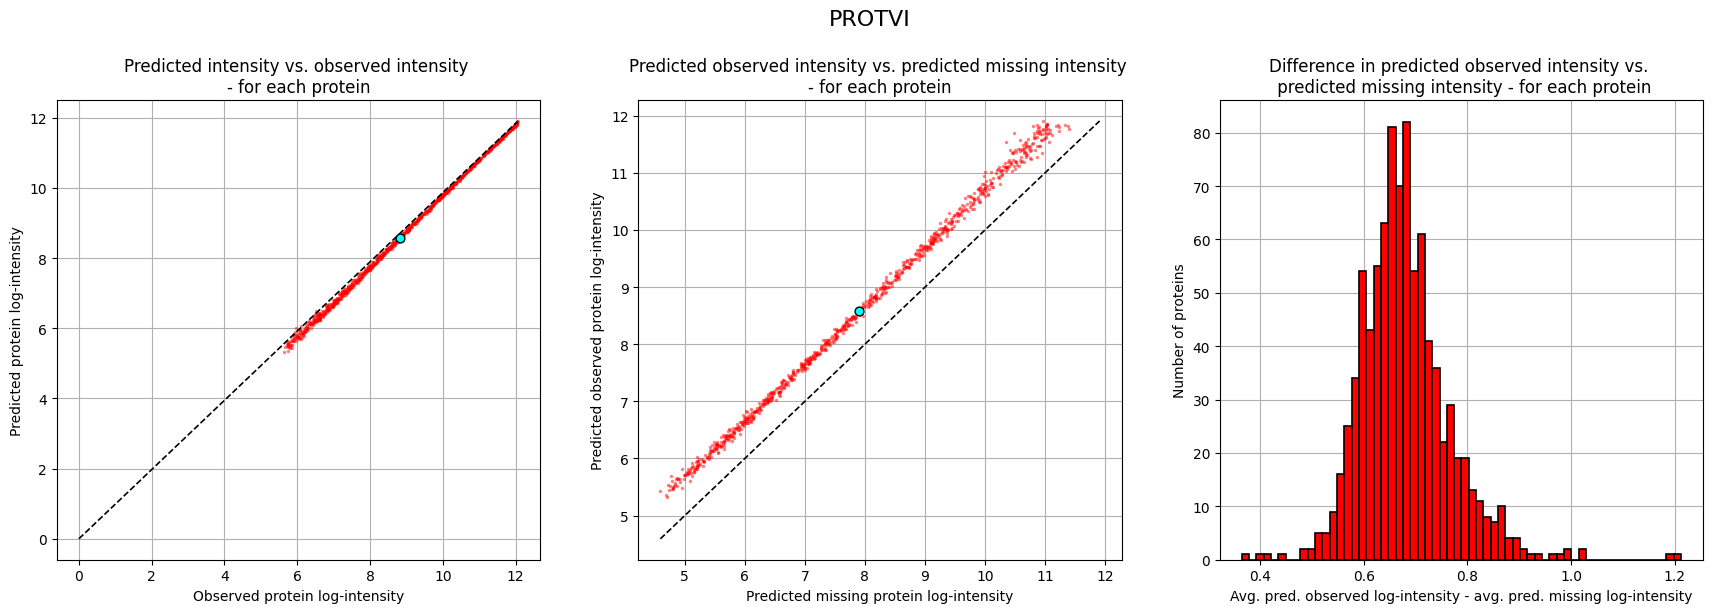

In [16]:
pl.plot_protein_intensity_panel(x_data, x_est, title="PROTVI")

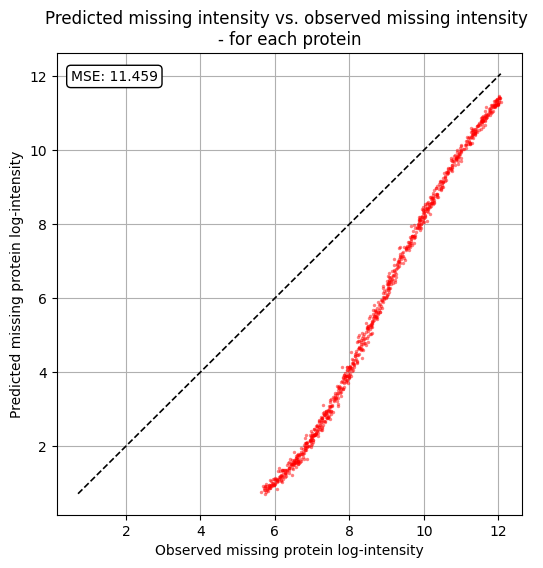

In [17]:
mask = adata.layers["detected"]

x_est_protein = np.nanmean(x_est * mask, axis=0)
x_protein = np.nanmean(x_data * mask, axis=0)

pl.scatter_compare_protein_missing_intensity(x_protein, x_est_protein)

In [18]:
mask = adata.layers["detected"]

x = adata.layers["intensity"].copy()

x_obs = x[mask]
x_miss = x[~mask]

x_est_obs = x_est[mask]
x_est_miss = x_est[~mask]

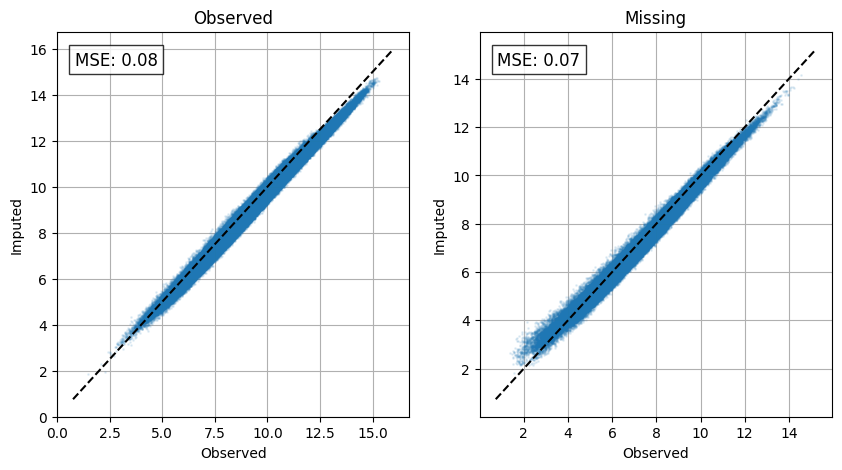

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(x_obs, x_est_obs, s=1, alpha=0.1)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, "--", c="k")

mse = np.mean((x_obs - x_est_obs)**2)
ax.text(0.05, 0.95, f"MSE: {mse:.2f}", transform=ax.transAxes, fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.8))

ax.set_xlabel("Observed")
ax.set_ylabel("Imputed")
ax.set_title("Observed")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.scatter(x_miss, x_est_miss, s=1, alpha=0.1)
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, "--", c="k")

mse = np.mean((x_miss - x_est_miss)**2)
ax.text(0.05, 0.95, f"MSE: {mse:.2f}", transform=ax.transAxes, fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.8))

ax.set_xlabel("Observed")
ax.set_ylabel("Imputed")
ax.set_title("Missing")
ax.grid(True)
ax.set_axisbelow(True)

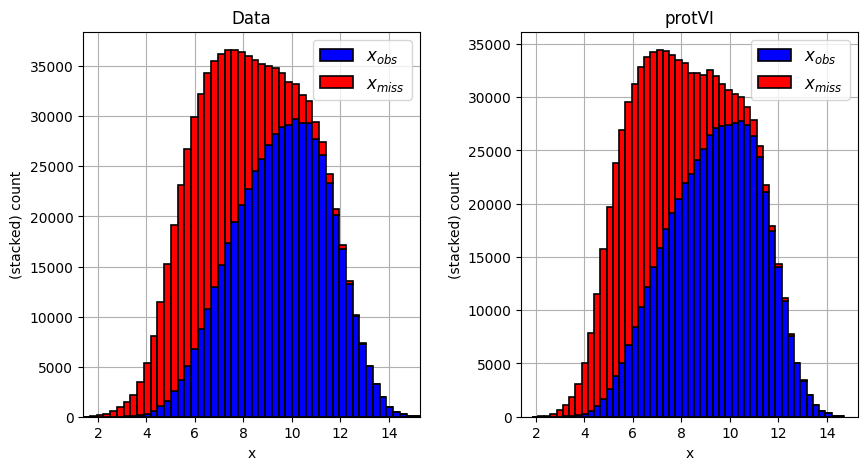

In [20]:
mask = adata.layers["detected"]
x = adata.layers["intensity"].copy()

x_obs = x[mask]
x_miss = x[~mask]

x_est_obs = x_est[mask]
x_est_miss = x_est[~mask]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3)

ax = axes[0]
ax.hist([x_obs, x_miss], color=["blue", "red"], bins=50, edgecolor="black", linewidth=1.2, stacked=True)
ax.set_title("Data")
ax.set_xlabel("x")
ax.set_ylabel("(stacked) count")
ax.set_xlim(np.min(x), np.max(x))
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(labels=["$x_{obs}$", "$x_{miss}$"], fontsize=12)

ax = axes[1]
ax.hist([x_est_obs, x_est_miss], color=["blue", "red"], bins=50, edgecolor="black", linewidth=1.2, stacked=True)
ax.set_title("protVI")
ax.set_xlabel("x")
ax.set_ylabel("(stacked) count")
ax.set_xlim(np.min(x), np.max(x))
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(labels=["$x_{obs}$", "$x_{miss}$"], fontsize=12)

### protDP

In [21]:
# @TODO

### Other impuation methods

In [22]:
# @TODO